In [1]:
import os

# Define paths to the image folders
part1_path = '/kaggle/input/dataset/HAM10000_images_part_1'
part2_path = '/kaggle/input/dataset/HAM10000_images_part_2'

# Count images in each part 
part1_count = len([
    f for f in os.listdir(part1_path)
    if os.path.isfile(os.path.join(part1_path, f)) and f.lower().endswith('.jpg')
])

part2_count = len([
    f for f in os.listdir(part2_path)
    if os.path.isfile(os.path.join(part2_path, f)) and f.lower().endswith('.jpg')
])

# Print the results
print(f"Images in part 1: {part1_count}")
print(f"Images in part 2: {part2_count}")
print(f"Total images: {part1_count + part2_count}")


Images in part 1: 5000
Images in part 2: 5015
Total images: 10015


In [ ]:
import os
import shutil
import pandas as pd

# Define paths
metadata_file = '/kaggle/input/dataset/HAM10000_metadata.csv'
images_part1 = '/kaggle/input/dataset/HAM10000_images_part_1'
images_part2 = '/kaggle/input/dataset/HAM10000_images_part_2'
output_dir = '/kaggle/working/HAM10000_rearranged'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load metadata
df = pd.read_csv(metadata_file)

# Get unique classes (e.g., 'nv', 'mel', etc.)
classes = df['dx'].unique()

# Create class subdirectories
for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

# Function to find image file path
def find_image_path(image_id):
    filename = image_id + '.jpg'
    path1 = os.path.join(images_part1, filename)
    path2 = os.path.join(images_part2, filename)
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None

# Rearrange images into class folders
missing_images = []
for _, row in df.iterrows():
    image_id = row['image_id']
    label = row['dx']
    src_path = find_image_path(image_id)
    
    if src_path:
        dst_path = os.path.join(output_dir, label, image_id + '.jpg')
        shutil.copy2(src_path, dst_path)
    else:
        missing_images.append(image_id)

# Report missing images if any
print(f"Completed rearranging. {len(missing_images)} missing images were found.")
if missing_images:
    print("Missing image IDs:", missing_images[:5])  # Print a few missing image IDs


Completed rearranging. 0 missing images were found.


In [ ]:
import os

# Path to your rearranged dataset folder 
dataset_dir = '/kaggle/working/HAM10000_rearranged'

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith('.jpg')
        ])
        print(f"{class_name}: {num_images} images")


bcc: 514 images
akiec: 327 images
nv: 6705 images
bkl: 1099 images
vasc: 142 images
mel: 1113 images
df: 115 images


In [ ]:
import os
import math
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Input and output directories
input_dir = "/kaggle/working/HAM10000_rearranged"
output_dir = "/kaggle/working/HAM10000_balanced_aug"
os.makedirs(output_dir, exist_ok=True)

# List of classes and target images per class
classes = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
target_count = 3000
target_size = (128, 128)  # Resize images to 128x128

# Define augmentation generator (for classes other than 'nv')
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

for cls in classes:
    print(f"Processing class: {cls}")
    class_input_dir = os.path.join(input_dir, cls)
    class_output_dir = os.path.join(output_dir, cls)
    os.makedirs(class_output_dir, exist_ok=True)

    # Get list of image filenames 
    original_images = [f for f in os.listdir(class_input_dir) if f.lower().endswith(('.jpg'))]
    num_original = len(original_images)
    print(f"  Found {num_original} original images.")

    saved_count = 0  # counter for how many images saved in output

    if cls == "nv":
        # For nv, simply sample 3000 images from the original list (after resizing)
        if num_original < target_count:
            print(f"  Warning: {cls} has fewer than {target_count} images. Copying all available images.")
            selected = original_images
        else:
            selected = random.sample(original_images, target_count)

        for filename in selected:
            src_path = os.path.join(class_input_dir, filename)
            try:
                # Load, resize, and save the image
                img = load_img(src_path, target_size=target_size)
                dst_path = os.path.join(class_output_dir, filename)
                img.save(dst_path)
                saved_count += 1
            except Exception as e:
                print(f"  Error processing {src_path}: {e}")
        print(f"  Saved {saved_count} images for class '{cls}'.")

    else:
        # For other classes, we need to augment so that total images = target_count.
        # First, calculate how many augmented images are needed.
        needed = target_count - num_original
        # Compute how many augmentations per original image (at least)
        aug_per_image = math.ceil(needed / num_original)
        print(f"  Each original will produce {aug_per_image} augmented images (approximately).")

        # Loop over each original image
        for filename in original_images:
            if saved_count >= target_count:
                break  # Stop if we've reached target

            src_path = os.path.join(class_input_dir, filename)
            try:
                # Load and resize the original image
                img = load_img(src_path, target_size=target_size)
            except Exception as e:
                print(f"  Error loading {src_path}: {e}")
                continue

            # Save the resized original image (suffix with "orig_")
            base_name, ext = os.path.splitext(filename)
            out_name = f"{base_name}_orig{ext}"
            dst_path = os.path.join(class_output_dir, out_name)
            try:
                img.save(dst_path)
                saved_count += 1
            except Exception as e:
                print(f"  Error saving {dst_path}: {e}")
                continue

            # Convert image to array and reshape for augmentation
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)  # shape: (1, 128, 128, channels)

            # Generate augmented images using the datagen.flow generator.
            aug_iter = datagen.flow(x, batch_size=1)
            for i in range(aug_per_image):
                if saved_count >= target_count:
                    break
                # Generate one augmented image
                batch = next(aug_iter)
                aug_img = array_to_img(batch[0])
                aug_filename = f"{base_name}_aug{i}{ext}"
                aug_dst = os.path.join(class_output_dir, aug_filename)
                try:
                    aug_img.save(aug_dst)
                    saved_count += 1
                except Exception as e:
                    print(f"  Error saving {aug_dst}: {e}")
        print(f"  Total images saved for class '{cls}': {saved_count}")

    # If for some reason we exceeded target_count, we can report or adjust here.
    if saved_count < target_count:
        print(f"  Note: Only {saved_count} images were produced for class '{cls}' (target was {target_count}).")
    elif saved_count > target_count:
        print(f"  Note: Produced {saved_count} images for class '{cls}', which exceeds the target of {target_count}.")

print("Augmented balanced dataset creation complete.")


2025-07-25 10:24:50.009332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753439090.242882      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753439090.316305      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing class: akiec
  Found 327 original images.
  Each original will produce 9 augmented images (approximately).
  Total images saved for class 'akiec': 3000
Processing class: bcc
  Found 514 original images.
  Each original will produce 5 augmented images (approximately).
  Total images saved for class 'bcc': 3000
Processing class: bkl
  Found 1099 original images.
  Each original will produce 2 augmented images (approximately).
  Total images saved for class 'bkl': 3000
Processing class: df
  Found 115 original images.
  Each original will produce 26 augmented images (approximately).
  Total images saved for class 'df': 3000
Processing class: mel
  Found 1113 original images.
  Each original will produce 2 augmented images (approximately).
  Total images saved for class 'mel': 3000
Processing class: nv
  Found 6705 original images.
  Saved 3000 images for class 'nv'.
Processing class: vasc
  Found 142 original images.
  Each original will produce 21 augmented images (approximate

In [5]:
import os

# Path to the rearranged dataset
rearranged_dir = "/kaggle/working/HAM10000_balanced_aug"

# Count images in each class folder
for class_name in sorted(os.listdir(rearranged_dir)):
    class_path = os.path.join(rearranged_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        num_images = len([img for img in os.listdir(class_path) if img.endswith('.jpg')])
        print(f"{class_name}: {num_images} images")


akiec: 3000 images
bcc: 3000 images
bkl: 3000 images
df: 3000 images
mel: 3000 images
nv: 3000 images
vasc: 3000 images


In [ ]:
import os
import random
import shutil

# Set input and output directories
input_dir = "/kaggle/working/HAM10000_balanced_aug"
output_dir = "/kaggle/working/HAM10000_split"
os.makedirs(output_dir, exist_ok=True)

# Define subdirectories for training, validation, and testing
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List the class directories (each class should be a subfolder in input_dir)
classes = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

for cls in classes:
    cls_input_dir = os.path.join(input_dir, cls)

    # Create corresponding output directories for this class
    cls_train_dir = os.path.join(train_dir, cls)
    cls_val_dir = os.path.join(val_dir, cls)
    cls_test_dir = os.path.join(test_dir, cls)
    os.makedirs(cls_train_dir, exist_ok=True)
    os.makedirs(cls_val_dir, exist_ok=True)
    os.makedirs(cls_test_dir, exist_ok=True)

    # Get all image filenames 
    images = [f for f in os.listdir(cls_input_dir) if f.lower().endswith(('.jpg'))]

    # Shuffle the images to ensure random splits
    random.shuffle(images)

    total_count = len(images)
    test_count = int(0.2 * total_count)           # 20% for testing
    train_val_count = total_count - test_count      # Remaining 80% for training+validation

    # Now split training+validation into 90% training and 10% validation
    val_count = int(0.1 * train_val_count)          # 10% of 80%
    train_count = train_val_count - val_count       # 90% of 80%

    # Create the splits
    test_images = images[:test_count]
    train_val_images = images[test_count:]
    train_images = train_val_images[:train_count]
    val_images = train_val_images[train_count:]

    # Copy files to the respective directories
    for img in train_images:
        src = os.path.join(cls_input_dir, img)
        dst = os.path.join(cls_train_dir, img)
        shutil.copy2(src, dst)

    for img in val_images:
        src = os.path.join(cls_input_dir, img)
        dst = os.path.join(cls_val_dir, img)
        shutil.copy2(src, dst)

    for img in test_images:
        src = os.path.join(cls_input_dir, img)
        dst = os.path.join(cls_test_dir, img)
        shutil.copy2(src, dst)

    print(f"Class '{cls}': {len(train_images)} training, {len(val_images)} validation, {len(test_images)} testing images.")

print("Data splitting complete.")


Class 'bcc': 2160 training, 240 validation, 600 testing images.
Class 'akiec': 2160 training, 240 validation, 600 testing images.
Class 'nv': 2160 training, 240 validation, 600 testing images.
Class 'bkl': 2160 training, 240 validation, 600 testing images.
Class 'vasc': 2160 training, 240 validation, 600 testing images.
Class 'mel': 2160 training, 240 validation, 600 testing images.
Class 'df': 2160 training, 240 validation, 600 testing images.
Data splitting complete.


In [ ]:
import os

# Base directory where the split data is stored
base_dir = "/kaggle/working/HAM10000_split"

# Define the splits you have
splits = ["train", "val", "test"]

# Define the image file extensions to look for
image_extensions = ('.jpg')

for split in splits:
    split_dir = os.path.join(base_dir, split)
    print(f"Counts for {split}:")

    # Iterate over each class subfolder
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            # Count files that have image extensions
            count = len([f for f in os.listdir(cls_path) if f.lower().endswith(image_extensions)])
            print(f"  {cls}: {count} images")
    print("-" * 40)


Counts for train:
  bcc: 2160 images
  akiec: 2160 images
  nv: 2160 images
  bkl: 2160 images
  vasc: 2160 images
  mel: 2160 images
  df: 2160 images
----------------------------------------
Counts for val:
  bcc: 240 images
  akiec: 240 images
  nv: 240 images
  bkl: 240 images
  vasc: 240 images
  mel: 240 images
  df: 240 images
----------------------------------------
Counts for test:
  bcc: 600 images
  akiec: 600 images
  nv: 600 images
  bkl: 600 images
  vasc: 600 images
  mel: 600 images
  df: 600 images
----------------------------------------


In [ ]:
import os
import numpy as np
from PIL import Image

# --- Paths & params ---
train_dir  = "/kaggle/working/HAM10000_split/train"
img_height = img_width = 224

# --- Compute mean & std on TRAIN set ---
channel_sum    = np.zeros(3, dtype=np.float64)
channel_sq_sum = np.zeros(3, dtype=np.float64)
pixel_count    = 0

for root, _, files in os.walk(train_dir):
    for fname in files:
        if not fname.lower().endswith((".jpg")):
            continue
        path = os.path.join(root, fname)
        img = Image.open(path).convert("RGB").resize((img_width, img_height))
        arr = np.asarray(img, dtype=np.float32) / 255.0
        channel_sum    += arr.sum(axis=(0,1))
        channel_sq_sum += (arr**2).sum(axis=(0,1))
        pixel_count    += img_width * img_height

mean = channel_sum / pixel_count
std  = np.sqrt(channel_sq_sum / pixel_count - mean**2)
print("Computed mean:", mean)
print("Computed std: ", std)

# --- Preprocessing function for ImageDataGenerator ---
def preprocess_fn(img):
    """
    img: HxWxC numpy array with values [0,255]
    Returns a float32 HxWxC array normalized by your computed mean/std.
    """
    img = img.astype(np.float32) / 255.0
    img = (img - mean) / std
    return img


Computed mean: [0.7943926  0.57079729 0.60930236]
Computed std:  [0.14481409 0.16752706 0.18225199]


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Mean and Std for Normalization (computed before) ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([[0.14481409, 0.16752706, 0.18225199]], dtype=np.float32)

# --- Paths & Params ---
base_dir    = "/kaggle/working/HAM10000_split"
train_dir   = os.path.join(base_dir, "train")
val_dir     = os.path.join(base_dir, "val")
test_dir    = os.path.join(base_dir, "test")
img_height  = img_width = 224  # EfficientNetB3 performs best at 300x300, but 224 is lighter
batch_size  = 32
num_classes = 7

# --- Preprocessing Function ---
def preprocess_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - mean) / std
    return img

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=False
)

# --- Build EfficientNetB3 Model ---
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# --- Compile ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/efficientnetb3_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Train ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, earlystop]
)

# --- Evaluate on test set ---
loss, acc = model.evaluate(test_gen)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

model.save('/kaggle/working/efficientnetb3.keras')


Found 15120 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.3484 - loss: 1.7980
Epoch 1: val_accuracy improved from -inf to 0.38333, saving model to /kaggle/working/efficientnetb3_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 386s 518ms/step - accuracy: 0.3486 - loss: 1.7972 - val_accuracy: 0.3833 - val_loss: 1.7703
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6588 - loss: 0.9070
Epoch 2: val_accuracy improved from 0.38333 to 0.70952, saving model to /kaggle/working/efficientnetb3_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 182s 383ms/step - accuracy: 0.6589 - loss: 0.9069 - val_accuracy: 0.7095 - val_loss: 0.7635
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7468 - loss: 0.6962
Epoch 3: val_accuracy improved from 0.70952 to 0.80298, saving model to /kaggle/working/efficientnetb3_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 180s 

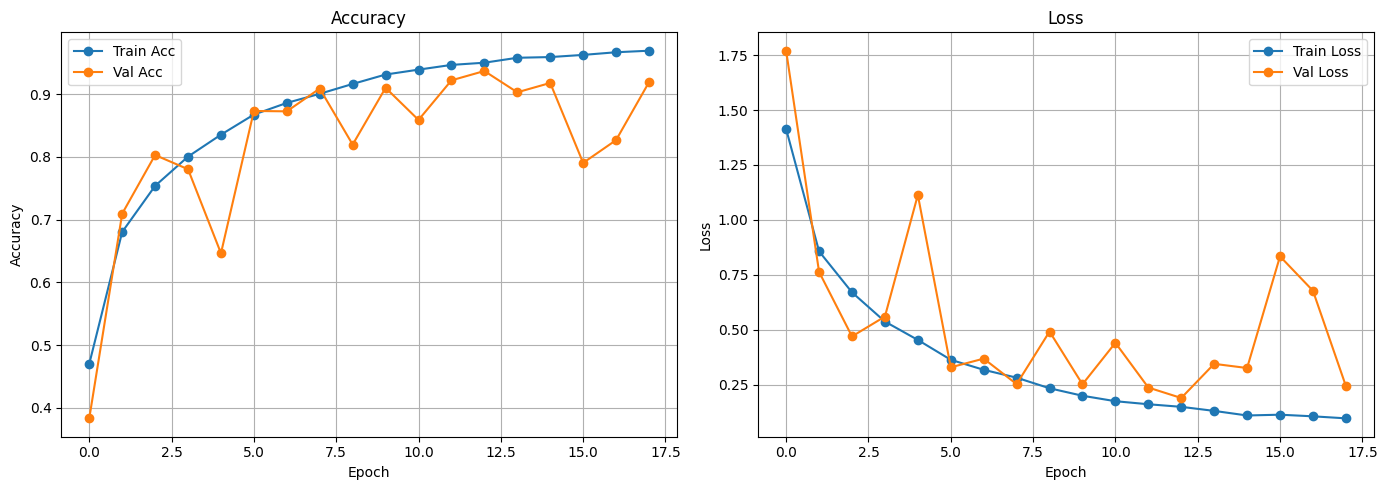

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- 1. Plot training & validation accuracy/loss ---
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


132/132 ━━━━━━━━━━━━━━━━━━━━ 30s 151ms/step


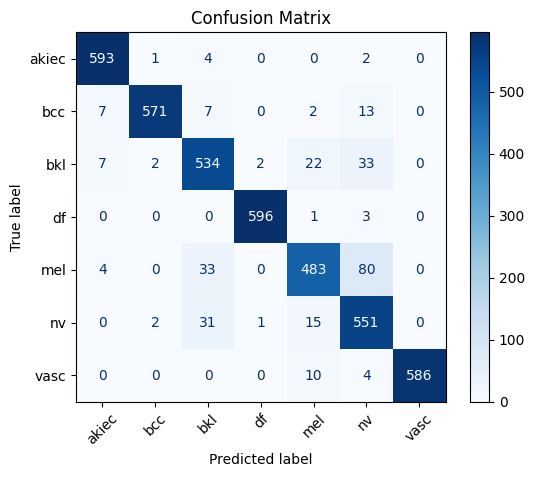

Classification Report:
              precision    recall  f1-score   support

       akiec       0.97      0.99      0.98       600
         bcc       0.99      0.95      0.97       600
         bkl       0.88      0.89      0.88       600
          df       0.99      0.99      0.99       600
         mel       0.91      0.81      0.85       600
          nv       0.80      0.92      0.86       600
        vasc       1.00      0.98      0.99       600

    accuracy                           0.93      4200
   macro avg       0.93      0.93      0.93      4200
weighted avg       0.93      0.93      0.93      4200



In [18]:
# --- Predict labels for test set ---
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# --- Class names (in order of directory names) ---
class_names = list(test_gen.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


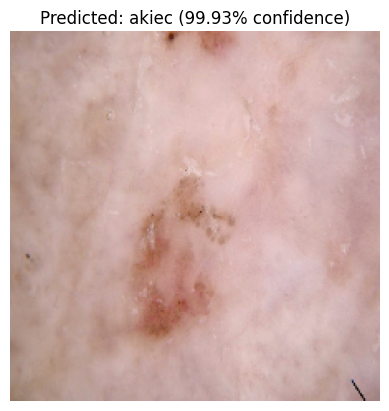

('akiec', 0.99929297)

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/akiec/ISIC_0024329.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


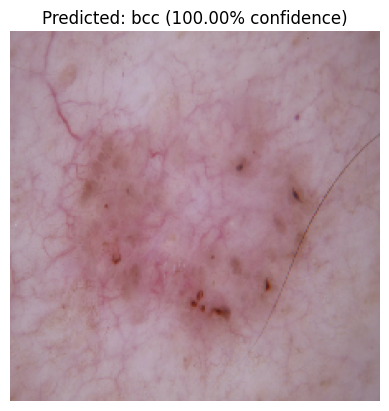

('bcc', 1.0)

In [21]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/bcc/ISIC_0024448.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


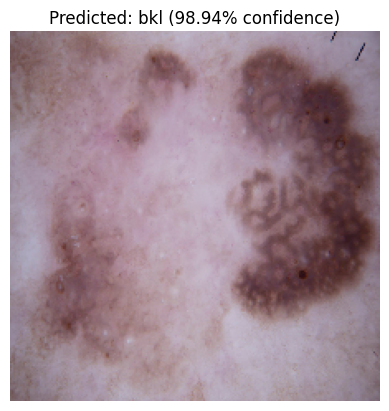

('bkl', 0.9894029)

In [22]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/bkl/ISIC_0024381.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


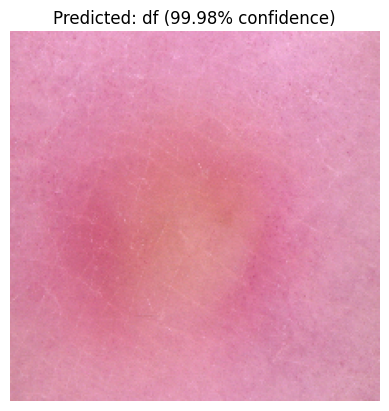

('df', 0.99981064)

In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/df/ISIC_0024994.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


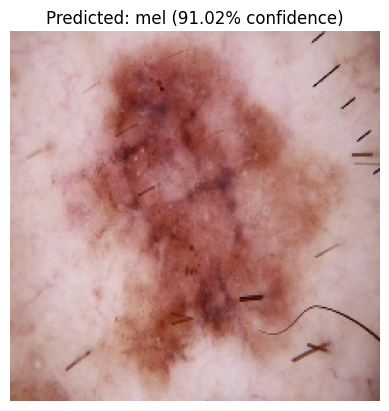

('mel', 0.9102134)

In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/mel/ISIC_0024482.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


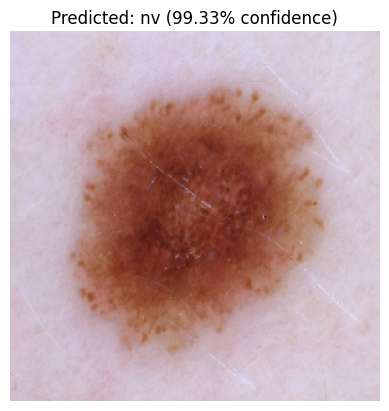

('nv', 0.9933193)

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/nv/ISIC_0024317.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


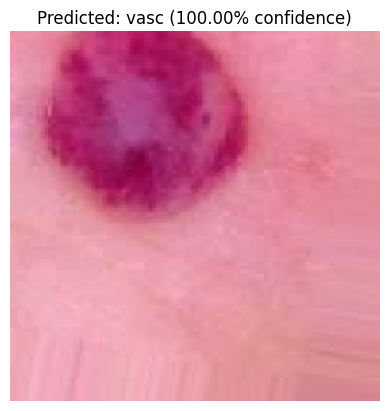

('vasc', 1.0)

In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_split/test/vasc/ISIC_0024370_aug20.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


In [27]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# --- Mean and Std for Normalization (computed before) ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)

# --- Paths & Params ---
base_dir    = "/kaggle/working/HAM10000_split"
train_dir   = os.path.join(base_dir, "train")
val_dir     = os.path.join(base_dir, "val")
test_dir    = os.path.join(base_dir, "test")
img_height  = img_width = 224  # ResNet50 prefers 224x224
batch_size  = 32
num_classes = 7

# --- Preprocessing Function ---
def preprocess_fn(img):
    img = img.astype(np.float32) / 255.0
    img = (img - mean) / std
    return img

# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical', shuffle=False
)

# --- Build ResNet50 Model ---
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
x = base_model.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# --- Compile ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/HAM10000_resnet50_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Train ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, earlystop]
)

# --- Evaluate on test set ---
loss, acc = model.evaluate(test_gen)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


Found 15120 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3395 - loss: 2.0416
Epoch 1: val_accuracy improved from -inf to 0.16369, saving model to /kaggle/working/HAM10000_resnet50_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 305s 467ms/step - accuracy: 0.3397 - loss: 2.0405 - val_accuracy: 0.1637 - val_loss: 4.3289
Epoch 2/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6059 - loss: 1.0535
Epoch 2: val_accuracy improved from 0.16369 to 0.72202, saving model to /kaggle/working/HAM10000_resnet50_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 189s 398ms/step - accuracy: 0.6060 - loss: 1.0533 - val_accuracy: 0.7220 - val_loss: 0.7190
Epoch 3/50
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7029 - loss: 0.8223
Epoch 3: val_accuracy improved from 0.72202 to 0.77083, saving model to /kaggle/working/HAM10000_resnet50_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 187s 395ms/step - accuracy: 0.7030 - loss: 0.8222 - val_accuracy: 0.7708 - val_loss: 0.6103
Epoch 4/50
473/473 ━━━━━━━━━━━━

In [28]:
model.save('/kaggle/working/resnet50.keras')

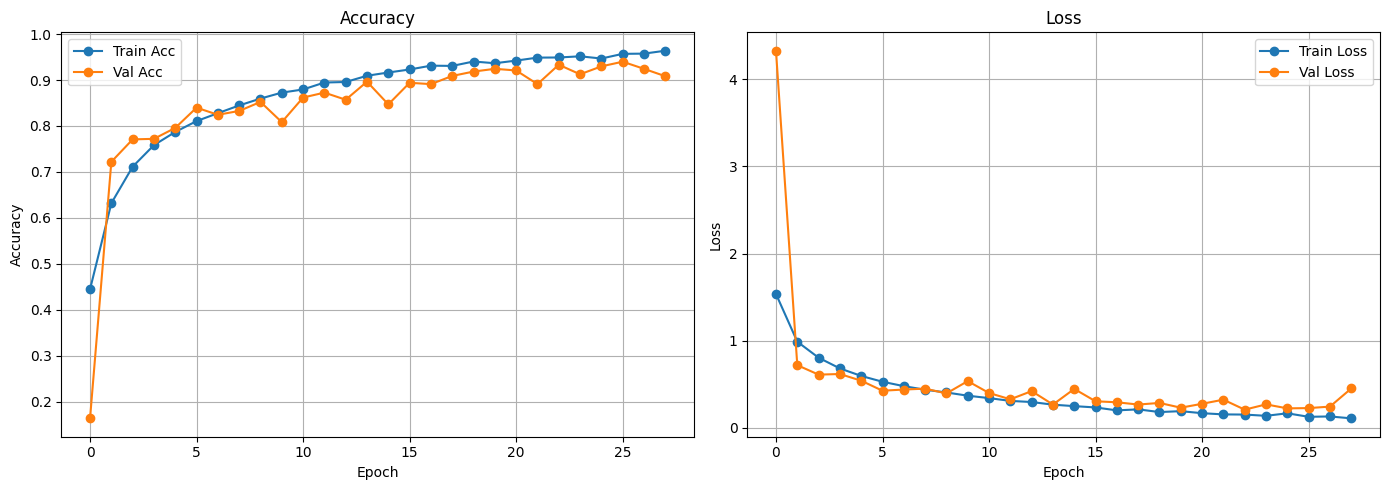

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- 1. Plot training & validation accuracy/loss ---
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step


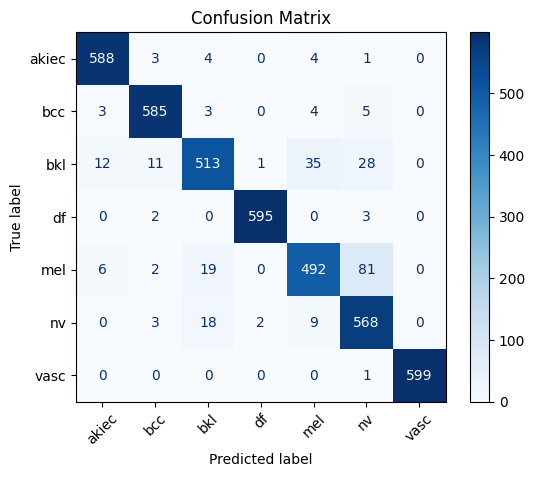

Classification Report:
              precision    recall  f1-score   support

       akiec       0.97      0.98      0.97       600
         bcc       0.97      0.97      0.97       600
         bkl       0.92      0.85      0.89       600
          df       0.99      0.99      0.99       600
         mel       0.90      0.82      0.86       600
          nv       0.83      0.95      0.88       600
        vasc       1.00      1.00      1.00       600

    accuracy                           0.94      4200
   macro avg       0.94      0.94      0.94      4200
weighted avg       0.94      0.94      0.94      4200



In [30]:
# --- Predict labels for test set ---
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# --- Class names (in order of directory names) ---
class_names = list(test_gen.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


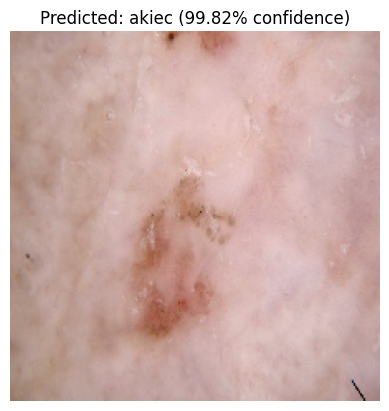

('akiec', 0.9982437)

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/akiec/ISIC_0024329.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


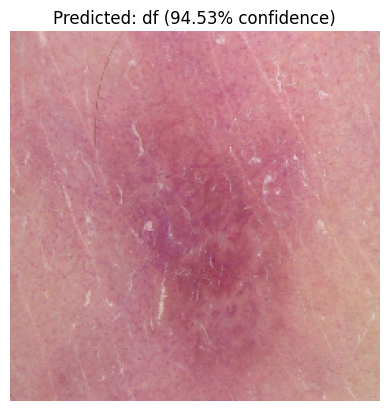

('df', 0.9453164)

In [32]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Use the same mean and std used in training ---
mean = np.array([0.7943926,  0.57079729, 0.60930236], dtype=np.float32)
std  = np.array([0.14481409, 0.16752706, 0.18225199], dtype=np.float32)


# --- Define class names (update if needed) ---
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# --- Function to preprocess and predict ---
def predict_skin_disease(img_path, model):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - mean) / std
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds)

    # Show results
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({confidence:.2%} confidence)")
    plt.show()

    return pred_class, confidence

# --- Usage ---
img_path = '/kaggle/working/HAM10000_rearranged/df/ISIC_0026254.jpg'  # <-- Change to your image path
predict_skin_disease(img_path, model)


In [33]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- Directory Paths ---
base_dir    = "/kaggle/working/HAM10000_split"  
train_dir   = os.path.join(base_dir, "train")
val_dir     = os.path.join(base_dir, "val")
test_dir    = os.path.join(base_dir, "test")

# --- Constants ---
img_height  = img_width = 128
batch_size  = 32
num_classes = 7
epochs      = 50

# --- Image Generators ---
train_gen = ImageDataGenerator().flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = ImageDataGenerator().flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# --- Custom CNN Architecture ---
input_tensor = Input(shape=(img_height, img_width, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output_tensor = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# --- Compile ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    filepath='custom_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Train ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint, earlystop]
)

# --- Evaluate ---
loss, acc = model.evaluate(test_gen)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")


Found 15120 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.
Found 4200 images belonging to 7 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2551 - loss: 1.9303
Epoch 1: val_accuracy improved from -inf to 0.39702, saving model to custom_cnn_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.2552 - loss: 1.9300 - val_accuracy: 0.3970 - val_loss: 1.5539
Epoch 2/50
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3829 - loss: 1.5947
Epoch 2: val_accuracy improved from 0.39702 to 0.46071, saving model to custom_cnn_model.h5
473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.3829 - loss: 1.5946 - val_accuracy: 0.4607 - val_loss: 1.3992
Epoch 3/50
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4255 - loss: 1.4808
Epoch 3: val_accuracy did not improve from 0.46071
473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.4255 - loss: 1.4807 - val_accuracy: 0.4202 - val_loss: 1.4530
Epoch 4/50
472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4564 - loss: 1.4170
Epoch 4: val_accuracy did not improve from 0.46071
473/473 ━━━━━━━━━━━━━━━

In [34]:
model.save('/kaggle/working/cnn.keras')


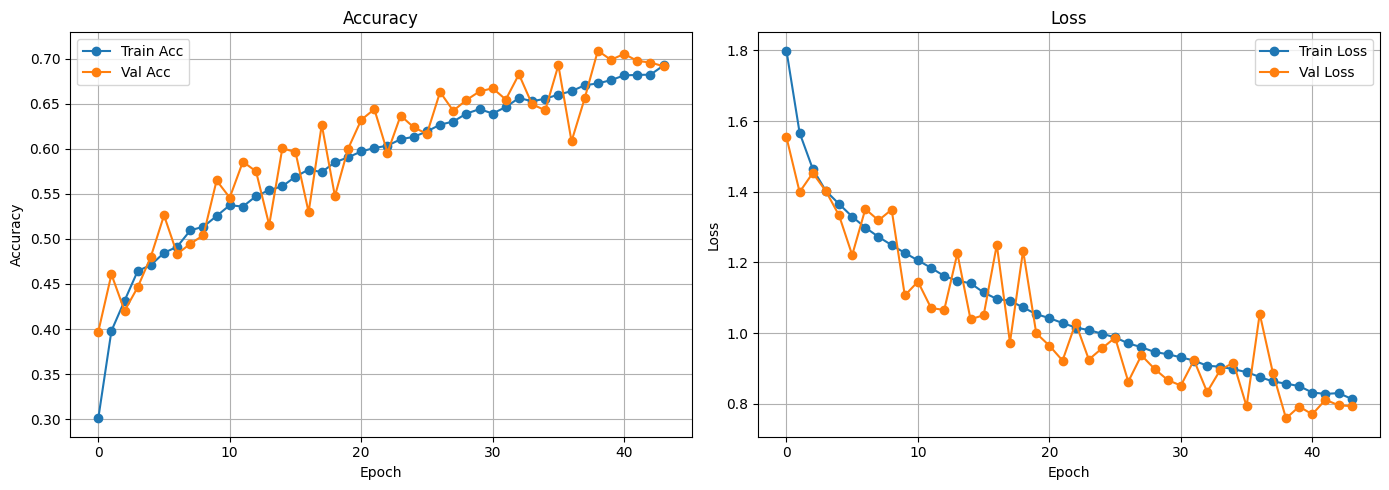

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- 1. Plot training & validation accuracy/loss ---
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


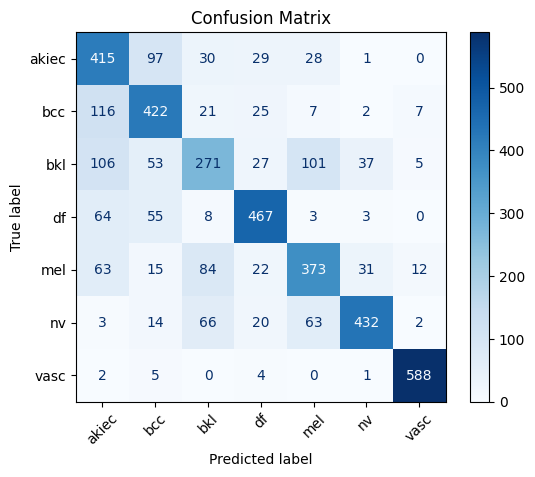

Classification Report:
              precision    recall  f1-score   support

       akiec       0.54      0.69      0.61       600
         bcc       0.64      0.70      0.67       600
         bkl       0.56      0.45      0.50       600
          df       0.79      0.78      0.78       600
         mel       0.65      0.62      0.63       600
          nv       0.85      0.72      0.78       600
        vasc       0.96      0.98      0.97       600

    accuracy                           0.71      4200
   macro avg       0.71      0.71      0.71      4200
weighted avg       0.71      0.71      0.71      4200



In [36]:
# --- Predict labels for test set ---
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# --- Class names (in order of directory names) ---
class_names = list(test_gen.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
